In [3]:
import shelve

import numpy as np
import matplotlib.pyplot as plt

In [4]:
# User parameters
out_base = "GRCh38-no_ambig.p14"
analysis_checkpoint_file_path = f"{out_base}-analysis-checkpoints.db"

# Run analysis

Since generating statistics can be time-consuming, these steps have been consolidated into two separate scripts that can be run outside of this notebook.  If the analysis has not yet been run, the following steps are required.

1. Download the human genome and decompress it.

```bash
wget https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/001/405/GCF_000001405.40_GRCh38.p14/GCF_000001405.40_GRCh38.p14_genomic.fna.gz
gzip -d GCF_000001405.40_GRCh38.p14_genomic.fna.gz
```

2. Build the $k$-mers for the human genome and sort them lexicographically.

```bash
python3 ./build_kmers.py -i GCF_000001405.40_GRCh38.p14_genomic.fna -o GRCh38.p14-kmers.hdf5
```

*Approximate run time: 2 hours*

3. Load the sorted $k$-mers and calculate the $k$-mer count distribution for a range of $k$ values.

```bash
python3 ./get_kmer_stats.py -i GRCh38.p14-kmers.hdf5 -o GRCh38.p14-analysis-checkpoints.db
```

*Approximate run time: 20 hours*

# Load analysis results from file

In [5]:
with shelve.open(analysis_checkpoint_file_path) as db:
    kmer_len_list = db["kmer_len_list"]
    
    group_hist_list = db["group_hist_list"]
    total_kmers_list = db["total_kmers_list"]
    run_times_all_list = db["run_times_all_list"]

    group_hist_unique_list = db["group_hist_unique_list"]
    total_kmers_unique_list = db["total_kmers_unique_list"]
    run_times_unique_list = db["run_times_unique_list"]

# Calculate $k$-mer group size distribution

Start by defnining some helper functions

In [7]:
def get_kmer_count_by_group_size(group_counts_by_group_size):
    """
    Given the group_counts_by_group_size histogram, calculate the 
    kmer_counts_by_group_size histogram.
    """
    return np.arange(len(group_counts_by_group_size)) * group_counts_by_group_size

def rebin_histogram(count_by_group_size: np.ndarray, num_bins:int=10):
    """
    Take the count_by_group_size histogram, which has bins of width 1, and rebin into
    num_bins that are spaced evenly in log-space.
    """
    # idx_min = min index with a non-zero value
    # idx_max = max index with a non-zero value + 1
    idx_min = 1
    idx_max = np.argwhere(count_by_group_size).max() + 1
    
    # calculate bin edges that are equally separated in log space
    idx_min_log = np.log10(idx_min)
    idx_max_log = np.log10(idx_max)
    bin_width_log = (idx_max_log - idx_min_log) / num_bins
    bin_edges_log = np.array([idx_min_log + i * bin_width_log for i in range(num_bins + 1)])

    # convert the bin edges in log space back to normal coordinates.
    bin_edges = np.power(10, bin_edges_log).astype(int)

    # Since we need bin indices, which are integers with discrete rather than continuous values, it
    # is possible that we would end up with bin edges [1, 1, 1, 2, 2, 3, 4, 6, ..].  Remove the repeated
    # indices for downstream processing. Note that we may end up with less than num_bins by doing this.
    bin_edges = np.unique(bin_edges)
    num_bins = len(bin_edges) - 1

    # Add one to the last bin edge since it's possible that it doesn't quite capture the last bin with a
    # non-zero value after the log space transformation
    bin_edges[-1] += 1

    # calculate the bin centers
    bin_centers = np.array([0.5*(bin_edges[i] + bin_edges[i-1]) for i in range(1, num_bins + 1)])

    # calculate the number of counts in each of the new bins
    bin_counts = []
    for i in range(num_bins):
        start_idx = bin_edges[i]
        end_idx = bin_edges[i+1]
        new_bin_count = count_by_group_size[start_idx:end_idx].sum()
        bin_counts.append(new_bin_count)
    bin_counts = np.array(bin_counts)
    
    # sanity check that we have counted everything in the original count_by_group_size array
    assert bin_counts.sum() == count_by_group_size.sum()

    return bin_edges, bin_centers, bin_counts
    

def normalize_histogram(bin_edges: np.ndarray, bin_counts: np.ndarray):
    """
    Normalize bin_counts s.t. the histogram integrates to 1.0.

    $sum_{i=1}^N bin_width_i * bin_count_i = 1$
    """
    bin_widths = np.array([bin_edges[i] - bin_edges[i-1] for i in range(1, len(bin_edges))])
    total = (bin_widths * bin_counts).sum()
    return bin_counts / total


def get_plot_data(group_hist_list: list[np.ndarray], 
                  kmer_lens_to_plot: list[int], 
                  kmer_len_list: list[int]):
    """
    Provided a list of kmer_lens, generate the k-mer frequency data to be
    plotted, which is the kmer_count as a function of kmer group size histogram
    that has been reformatted to have bins distributed in log-space.

    Returns:
        bin_centers_list, bin_counts_list, norm_bin_counts_list
    """
    bin_centers_list, bin_counts_list, norm_bin_counts_list = [], [], []
    for kmer_len in kmer_lens_to_plot:
        n = kmer_len_list.index(kmer_len)
        group_count_by_group_size = group_hist_list[n].todense()

        # convert histogram from group_count to kmer_count
        kmer_count_by_group_size = get_kmer_count_by_group_size(group_count_by_group_size)

        # rebin the histogram with the bins equidistant in log-space
        bin_edges, bin_centers, bin_counts = rebin_histogram(kmer_count_by_group_size, num_bins=50)

        # normalize so that it integrates to 1
        norm_bin_counts = normalize_histogram(bin_edges, bin_counts)
    
        # add to lists of values
        bin_centers_list.append(bin_centers)
        norm_bin_counts_list.append(norm_bin_counts)
        bin_counts_list.append(bin_counts)

    return bin_centers_list, bin_counts_list, norm_bin_counts_list


Plot the $k$-mer group size distribution for multiple values of $k$.

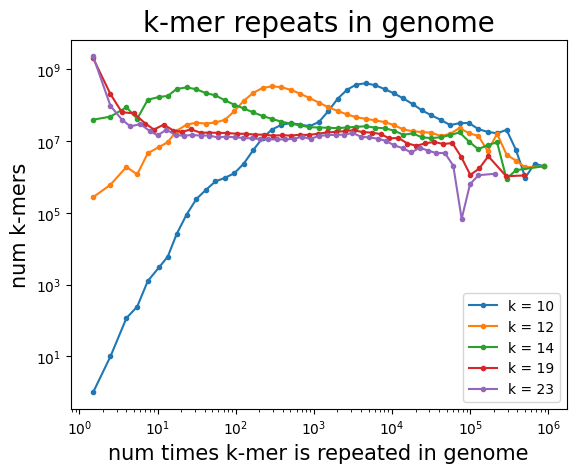

In [12]:
fig, ax = plt.subplots()

kmer_lens_to_plot = [10, 12, 14, 19, 23]
bin_centers_list, bin_counts_list, _ = get_plot_data(group_hist_list, kmer_lens_to_plot, kmer_len_list)

zipped_data = zip(kmer_lens_to_plot, bin_centers_list, bin_counts_list)
for kmer_len, bin_centers, bin_counts in zipped_data:
    # drop any bins with a zero count since this throws off log log plotting
    idx = (bin_counts != 0)
    bin_centers = bin_centers[idx]
    bin_counts = bin_counts[idx]

    # plot the data
    ax.loglog(bin_centers, bin_counts, "-o", markersize=3, label=f"k = {kmer_len}")

ax.set_title("k-mer repeats in genome", fontsize=20)
ax.set_xlabel("num times k-mer is repeated in genome", fontsize=15)
ax.set_ylabel("num k-mers", fontsize=15)
ax.legend();

# save figure to file
fig.savefig(f"{out_base}-kmer-group-size-dist.png", dpi=300)